In [1]:
# sources:
# https://tensorflow-object-detection-api-tutorial.readthedocs.io/en/latest/auto_examples/object_detection_camera.html#sphx-glr-auto-examples-object-detection-camera-py

# k-means clustering
# https://www.thepythoncode.com/article/kmeans-for-image-segmentation-opencv-python

# drawing clusters:
# https://docs.opencv.org/master/d0/d86/tutorial_py_image_arithmetics.html

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'    # Suppress TensorFlow logging
import tensorflow as tf
import cv2
import numpy as np
from object_detection.utils import label_map_util
from object_detection.utils import config_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder
tf.get_logger().setLevel('ERROR')
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import operator
%matplotlib notebook

In [2]:
PATH_TO_LABELS = 'training_v1/annotations/label_map.pbtxt'
PATH_TO_CKPT = 'training_v1/exported-models/my_ssd_resnet50_v1_fpn_export/checkpoint'
PATH_TO_CFG = 'training_v1/exported-models/my_ssd_resnet50_v1_fpn_export/pipeline.config'

In [3]:
# Enable GPU dynamic memory allocation
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

# Load pipeline config and build a detection model
configs = config_util.get_configs_from_pipeline_file(PATH_TO_CFG)
model_config = configs['model']
detection_model = model_builder.build(model_config=model_config, is_training=False)

# Restore checkpoint
ckpt = tf.compat.v2.train.Checkpoint(model=detection_model)
ckpt.restore(os.path.join(PATH_TO_CKPT, 'ckpt-0')).expect_partial()
        
# cropping the image to the size of the box
def crop_image(img, box):
    ymin, xmin, ymax, xmax = box
    crop_image = img[int(ymin*img.shape[0]):int(ymax*img.shape[0]), int(xmin*img.shape[1]):int(xmax*img.shape[1])]
    return crop_image

# convert image from BGR to RBG
def convert_bgr2rgb(img):
    conv_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return conv_img

@tf.function
def detect_fn(image):
    """Detect objects in image."""

    image, shapes = detection_model.preprocess(image)
    prediction_dict = detection_model.predict(image, shapes)
    detections = detection_model.postprocess(prediction_dict, shapes)

    return detections, prediction_dict, tf.reshape(shapes, [-1])

category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS,use_display_name=True)

In [4]:
# perform k-mean clustering on cropped image:
def perform_clustering(image):
    # reshape the image to a 2D array of pixels and 3 color values (RGB)
    pixel_values = image.reshape((-1, 3))
    # convert to float
    pixel_values = np.float32(pixel_values)
    # define stopping criteria
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2)
    # number of clusters (K)
    k = 4
    _, labels, (centers) = cv2.kmeans(pixel_values, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)
    # convert back to 8 bit values
    centers = np.uint8(centers)
    # flatten the labels array
    labels = labels.flatten()
    # convert all pixels to the color of the centroids
    segmented_image = centers[labels.flatten()]
    # reshape back to the original image dimension
    segmented_image = segmented_image.reshape(image.shape)
    return segmented_image

# add clustered pixels to original frame
def diplay_cluster(img1, img2, box):
    # I want to put logo on top-left corner, So I create a ROI
    rows,cols,channels = img2.shape
    roi = img1[int(box[0]*img1.shape[0]):rows+int(box[0]*img1.shape[0]), int(box[1]*img1.shape[1]):cols+int(box[1]*img1.shape[1])]
    # Now create a mask of logo and create its inverse mask also
    img2gray = cv2.cvtColor(img2,cv2.COLOR_BGR2GRAY)
    
    # get biggest cluster:
    #print(np.unique(img2gray))
    sum_of_pixe_per_cluster = {}
    for i in np.unique(img2gray):
        sum_of_pixe_per_cluster[str(i)] = sum(img2gray.flatten() == i)
    
    value = int(max(sum_of_pixe_per_cluster.items(), key=operator.itemgetter(1))[0])
    
    #sum_of_pixe_per_cluster.sort()
    #print(value)
    #print(sum_of_pixe_per_cluster)
#     in_range = False
#     for i in range(len(np.unique(img2gray))):
#         if 160 < np.unique(img2gray)[i] < 170:
#             in_range = True
            
#         if (i+1 == len(np.unique(img2gray))) and (in_range==False):
#             print(np.unique(img2gray))
    
    ret, mask = cv2.threshold(img2gray, value, value+5, cv2.THRESH_BINARY)
    mask_inv = cv2.bitwise_not(mask)
    # Now black-out the area of logo in ROI
    img1_bg = cv2.bitwise_and(roi,roi,mask = mask_inv)
    # Take only region of logo from logo image.
    img2_fg = cv2.bitwise_and(img2,img2,mask = mask)
    # Put logo in ROI and modify the main image
    dst = cv2.add(img1_bg,img2_fg)
    img1[int(box[0]*img1.shape[0]):rows+int(box[0]*img1.shape[0]), int(box[1]*img1.shape[1]):cols+int(box[1]*img1.shape[1])] = dst
    splash_size = sum(mask.flatten() != 0)
    return img1, splash_size

In [5]:
# predict and plot:
def predict_and_plot(video_path):
    cap = cv2.VideoCapture(video_path)
    predicted_frames = 0

    fig = plt.figure()
    viewer = fig.add_subplot()
    plt.ion() # Turns interactive mode on (probably unnecessary)
    fig.show() # Initially shows the figure
    
    biggest_splash = [0,0,0]

    while True:
        # Read frame from camera#
        ret, image_np = cap.read()
        if ret == True:
            predicted_frames += 1
            rgb_image = convert_bgr2rgb(image_np)
            
            # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
            image_np_expanded = np.expand_dims(rgb_image, axis=0)

            input_tensor = tf.convert_to_tensor(np.expand_dims(rgb_image, 0), dtype=tf.float32)
            detections, predictions_dict, shapes = detect_fn(input_tensor)

            label_id_offset = 1
            image_np_with_detections = rgb_image.copy()
            # image, box = 
            image, box = viz_utils.visualize_boxes_and_labels_on_image_array(
                image_np_with_detections,
                detections['detection_boxes'][0].numpy(),
                (detections['detection_classes'][0].numpy() + label_id_offset).astype(int),
                detections['detection_scores'][0].numpy(),
                category_index,
                use_normalized_coordinates=True,
                max_boxes_to_draw=2,
                min_score_thresh=.40,
                agnostic_mode=False)
            
#             viewer.clear() # Clears the previous image
#             viewer.imshow(image) # Loads the new image
#             plt.pause(.1)
#             fig.canvas.draw() # Draws the image to the screen   
#             print(box)

            if box[0] != 0:
                croped_img = crop_image(image_np_with_detections, box)
                cluster_image = perform_clustering(croped_img)
                #cluster_rgb = convert_bgr2rgb(cluster_image)
                full_image, splash_size = diplay_cluster(image, cluster_image, box)
                
                if biggest_splash[1] < splash_size:
                    biggest_splash[0] = predicted_frames
                    biggest_splash[1] = splash_size
                    biggest_splash[2] = full_image
                    
                # Display output
                #rgb_img = convert_bgr2rgb(full_image)
                splash_text = 'Splash: ' + str(splash_size) +' pixels'
                #print(splash_text)
                viewer.clear() # Clears the previous image
                viewer.imshow(full_image) # Loads the new image
                viewer.set_title(splash_text)
                #plt.pause(.1) # Delay in seconds
                fig.canvas.draw() # Draws the image to the screen
                
            else:
                #rgb_img = convert_bgr2rgb(image)
                viewer.clear() # Clears the previous image
                viewer.imshow(image) # Loads the new image
                #plt.pause(.1)
                viewer.set_title('No Splash')
                fig.canvas.draw() # Draws the image to the screen
                
        else:
            break

    cap.release()
    print('Biggest splash:', biggest_splash[1])
    print('Is frame:', biggest_splash[0])
    #viewer.clear() # Clears the previous image
    #viewer.imshow(biggest_splash[2]) # Loads the new image
    #viewer.set_title('Biggest Splash')
    #fig.canvas.draw() # Draws the image to the screen
    #print(predicted_frames)

benchmark.mp4


<IPython.core.display.Javascript object>


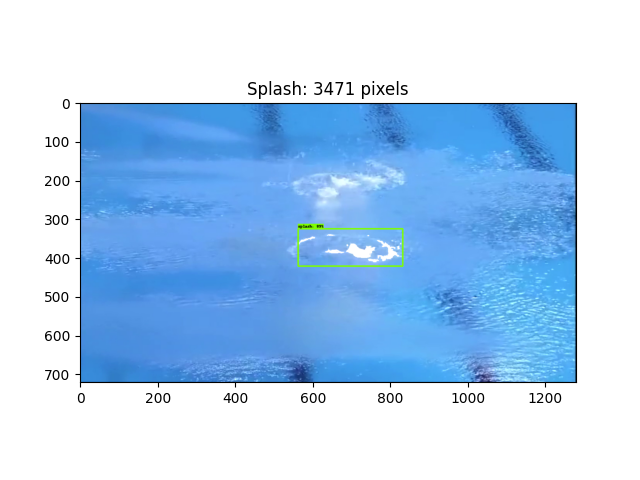

Biggest splash: 23868
Is frame: 76


In [6]:
# making predictions for all videos in a directory
directory = 'test_videos/'
#file_paths = os.listdir(directory)
file_paths = ['benchmark.mp4']
for path in file_paths:
    print(path)
    predict_and_plot(directory +path)